In [1]:
import os
import sys
sys.path.insert(0, '..')

from google.cloud import bigquery
from google.oauth2 import service_account

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt
from decouple import config
import json
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression

from authenticate_service_account import main
from utils import *

from sklearn.model_selection import train_test_split

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score

import category_encoders as ce
from scipy import stats

from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsRegressor

from keras.models import load_model

from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers, Sequential

from joblib import dump, load

from sklearn.ensemble import RandomForestRegressor


In [2]:
def create_df_of_all_categories(raw_data, data_to_be_processed, column):
    """
    This creates a list of all categories, and appends it to existing data that needs processing
    it appends the data, processes it, and drops the unnecesary columns
    It then appends it back to the dataframe so it can be used in the next step
    """

    # Creating dummy data
    categories  = pd.DataFrame(raw_data[column].unique(), columns=[column])

    #Isolating the important data
    # data_for_processing = data_to_be_processed[[column]].copy()

    # Merged data for encoding
    merged_data = pd.concat([data_to_be_processed,categories])

    return merged_data


In [3]:
def ants_preprocess(data):
    data_with_od = create_od_column(data, ['OriginCty', 'DestinationCty'])

    data_with_layover = calculate_total_layover_time(data_with_od, as_ratio=True)

    data_with_layover2 = calculate_distance_difference(data_with_layover, as_ratio=True)

    data_with_redirect_ratio = redirect_ratio(data_with_layover2)

    droped_values = drop_neg_layover_time(data_with_redirect_ratio)

    return droped_values


In [4]:
def convert_bool_to_num(value):
    return 0 if value else 1


In [5]:
data = pd.read_csv('../raw_data/all_data_30_horizon_with_day_of_week')
data.dropna(subset=['OriginApt', 'DestinationCty'], inplace=True)

economy_flights = data[data['PricePerPax']< 1500].copy()

processed_data = ants_preprocess(economy_flights)


In [6]:
# Creating our target
df_with_target = scale_itin_redirects(processed_data, 'ItineraryRedirects', 0, 50)


In [7]:
# fig, axs = plt.subplots(4, 1, figsize=(20, 20))
# sns.scatterplot(data=df_with_target, x='ODRedirects', y='Score_Z_score_0_50', hue='redirect_ratio', ax=axs[0], legend=False)
# sns.scatterplot(data=df_with_target, x='ODRedirects', y='Score_Z_score', hue='redirect_ratio', ax=axs[1], legend=False)
# sns.scatterplot(data=df_with_target, x='ODRedirects', y='Score_min_max', hue='redirect_ratio', ax=axs[2], legend=False)
# sns.scatterplot(data=df_with_target, x='ODRedirects', y='MinMax_Scaled', hue='redirect_ratio', ax=axs[3], legend=False)

# for ax in axs:
#     ax.set_xlim(-5, 500)


In [8]:
columns = ['Stops','DurationMin', 'total_layover_time_ratio', 'OriginApt', 'DestinationApt',
            'total_distance_traveled','extra_travel_distance_ratio', 'TravelHorizonDays', 'dayofweek',
            'TravelDistanceKm', 'PricePerPax', 'SelfTransfer']

box_cox_columns = ['DurationMin', 'TravelDistanceKm','extra_travel_distance_ratio', 'PricePerPax']

yeo_johnson_columns = ['total_layover_time_ratio', 'total_distance_traveled']

min_max_scaling = ['TravelHorizonDays','Stops']


In [9]:
df_with_target[columns].shape


(3597748, 12)

In [13]:
df_with_target

,OriginApt,OriginCty,OriginCtry,DestinationApt,DestinationCty,DestinationCtry,TravelHorizonDays,TravelDistanceKm,SelfTransfer,Stops,...,total_layover_time,total_layover_time_ratio,total_distance_traveled,extra_travel_distance_ratio,redirect_ratio,Z_Score,MinMax_Scaled,Score_min_max,Score_Z_score,Score_Z_score_0_50
31,AAL,AAL,DK,PEK,BJS,CN,28,7242.0,False,1,...,250.0,0.308642,7436.0,1.026788,1.000000,1.000000,1.000000,1.945910,1.945910,4.105183
32,AAL,AAL,DK,YYZ,YTO,CA,10,6039.0,False,1,...,135.0,0.194245,6614.0,1.095214,1.000000,NaN,0.000000,0.000000,NaN,NaN
33,ABY,ABY,US,LAX,LAX,US,22,3196.0,False,1,...,110.0,0.236559,3361.0,1.051627,1.000000,NaN,0.000000,0.000000,NaN,NaN
34,ABZ,ABZ,GB,MEX,MEX,MX,3,8604.0,False,1,...,160.0,0.169492,9911.0,1.151906,0.333333,0.169031,0.500000,1.151293,0.389208,3.051040
35,ACC,ACC,GH,BHX,BHX,GB,17,5212.0,False,1,...,145.0,0.232000,5321.0,1.020913,0.166667,-0.496341,0.000000,0.000000,-0.965834,2.206968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3699660,ZRH,ZRH,CH,WAW,WAW,PL,0,1031.0,False,0,...,0.0,0.000000,1031.0,1.000000,0.027027,-0.502888,0.000000,0.000000,-1.829297,2.198663
3699661,ZRH,ZRH,CH,WAW,WAW,PL,0,1031.0,False,0,...,0.0,0.000000,1031.0,1.000000,0.054054,-0.033142,0.040000,0.145503,-0.120555,2.794569
3699662,ZTH,ZTH,GR,PRG,PRG,CZ,2,1470.0,False,0,...,0.0,0.000000,1470.0,1.000000,0.304348,0.746749,0.171429,0.544809,2.373208,3.783916
3699663,ZTH,ZTH,GR,PRG,PRG,CZ,2,1470.0,False,0,...,0.0,0.000000,1470.0,1.000000,0.173913,0.139859,0.085714,0.272405,0.444481,3.014033


In [18]:
o_encoder = ce.BinaryEncoder()
df_binary = o_encoder.fit_transform(df_with_target['OriginApt'])

In [19]:
df_binary

,OriginApt_0,OriginApt_1,OriginApt_2,OriginApt_3,OriginApt_4,OriginApt_5,OriginApt_6,OriginApt_7,OriginApt_8,OriginApt_9,OriginApt_10,OriginApt_11
31,0,0,0,0,0,0,0,0,0,0,0,1
32,0,0,0,0,0,0,0,0,0,0,0,1
33,0,0,0,0,0,0,0,0,0,0,1,0
34,0,0,0,0,0,0,0,0,0,0,1,1
35,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3699660,0,0,1,0,0,1,0,1,0,1,0,1
3699661,0,0,1,0,0,1,0,1,0,1,0,1
3699662,0,0,1,0,0,1,0,1,0,1,1,0
3699663,0,0,1,0,0,1,0,1,0,1,1,0


In [10]:
def feature_engineering(processed_data, columns_to_process, target,
                        box_cox_columns=False, yeo_johnson_columns=False, min_max_scaling=False, log_transform_columns=False,
                        return_encoders=True):

    # Seperating target so encoders dont store a df shape that is larger than real-world data
    y = processed_data[target]

    # creating a new data variable that avoids warnings
    model_data = processed_data[columns_to_process].copy()

    #Binary encoding origin and destination
    o_encoder = ce.BinaryEncoder(cols=['OriginApt'])
    df_binary = o_encoder.fit_transform(model_data)

    d_encoder = ce.BinaryEncoder(cols=['DestinationApt'])
    all_binary = d_encoder.fit_transform(df_binary)

    # Scaling other features
    # Box cox
    if box_cox_columns == False:
        box_lambda = 0
    else:
        for col in box_cox_columns:
            all_binary[col], box_lambda = stats.boxcox(all_binary[col])

    # Yeo-johnson
    if yeo_johnson_columns == False:
        yeo_lambda = 0
    else:
        for col in yeo_johnson_columns:
            all_binary[col], yeo_lambda = stats.yeojohnson(all_binary[col])

    # Log transformations
    if log_transform_columns == False:
        pass
    else:
        for column in log_transform_columns:
            all_binary.loc[:, column] = np.log1p(model_data[column])

    #Min max scaling
    if min_max_scaling == False:
        minmax_scaler= 0
    else:
        minmax_scaler = MinMaxScaler()
        all_binary[min_max_scaling] = minmax_scaler.fit_transform(all_binary[min_max_scaling])

    # Cyclical encoding
    all_binary['sin_day'] = np.sin(2 * np.pi * all_binary['dayofweek'] / 7)
    all_binary['cos_day'] = np.cos(2 * np.pi * all_binary['dayofweek'] / 7)

    all_binary.drop(columns='dayofweek', inplace=True)

    all_binary['SelfTransfer'] = all_binary['SelfTransfer'].apply(convert_bool_to_num)

    # # Binary encoding Operator IATA'
    # seg_0_encoder = ce.BinaryEncoder(cols=['Seg_0_OperatingCarrierIATA'])
    # seg_0_binary = seg_0_encoder.fit_transform(all_binary)

    # seg_1_encoder = ce.BinaryEncoder(cols=['Seg_1_OperatingCarrierIATA'])
    # seg_1_binary = seg_1_encoder.fit_transform(seg_0_binary)

    # seg_2_encoder = ce.BinaryEncoder(cols=['Seg_2_OperatingCarrierIATA'])
    # seg_2_binary = seg_2_encoder.fit_transform(seg_1_binary)

    # seg_3_encoder = ce.BinaryEncoder(cols=['Seg_3_OperatingCarrierIATA'])
    # seg_3_binary = seg_3_encoder.fit_transform(seg_2_binary)

    if return_encoders == False:
        all_binary[target] = y

        return all_binary
    else:
        class PreprocessScalers:
            def __init__(self, o_encoder, d_encoder, box_lambda, yeo_lambda, minmax_scaler):
                self.o_encoder = o_encoder
                self.d_encoder = d_encoder
                self.box_lambda = box_lambda
                self.yeo_lambda = yeo_lambda
                self.minmax_scaler = minmax_scaler
                # self.seg_0_encoder = seg_0_encoder
                # self.seg_1_encoder = seg_1_encoder
                # self.seg_2_encoder = seg_2_encoder
                # self.seg_3_encoder = seg_3_encoder

        scalers = PreprocessScalers(o_encoder, d_encoder, box_lambda, yeo_lambda, minmax_scaler)

        all_binary[target] = y

        return all_binary, scalers


In [11]:
def process_new_data(original_data, new_data, PreprocessScalers, box_cox_columns, yeo_johnson_columns):


    #Binary encoding origin
    df_binary = PreprocessScalers.o_encoder.transform(new_data)

    print(df_binary.shape)

    # Binary encoding Destination
    all_destination_cats = create_df_of_all_categories(original_data, df_binary, 'DestinationApt')
    all_binary = PreprocessScalers.d_encoder.transform(all_destination_cats)
    all_binary.dropna(subset='Stops', inplace=True)

    print(all_binary.shape)

    # Scaling other features

    # Box cox
    for col in box_cox_columns:
        all_binary[col]  = stats.boxcox(all_binary[col], lmbda=PreprocessScalers.box_lambda)

    print(all_binary.shape)

    # Yeo-johnson
    for col in yeo_johnson_columns:
        all_binary[col] = stats.yeojohnson(all_binary[col], lmbda=PreprocessScalers.yeo_lambda)

    print(all_binary.shape)

    #Min max scaling
    all_binary[min_max_scaling] = PreprocessScalers.minmax_scaler.transform(all_binary[min_max_scaling])

    print(all_binary.shape)

    # Cyclical encoding
    all_binary['sin_day'] = np.sin(2 * np.pi * all_binary['dayofweek'] / 7)
    all_binary['cos_day'] = np.cos(2 * np.pi * all_binary['dayofweek'] / 7)

    all_binary.drop(columns=['dayofweek'], inplace=True)

    print(all_binary.shape)

    all_binary['SelfTransfer'] = all_binary['SelfTransfer'].apply(convert_bool_to_num)


    # # Binary encoding Operator IATA'
    # seg_0_cats = create_df_of_all_categories(original_data, all_binary, 'Seg_0_OperatingCarrierIATA')
    # seg_0_binary = PreprocessScalers.seg_0_encoder.transform(seg_0_cats)
    # seg_0_binary.dropna(subset='Stops', inplace=True)

    # seg_1_cats = create_df_of_all_categories(original_data, seg_0_binary, 'Seg_1_OperatingCarrierIATA')
    # seg_1_binary = PreprocessScalers.seg_1_encoder.transform(seg_1_cats)
    # seg_1_binary.dropna(subset='Stops', inplace=True)

    # seg_2_cats = create_df_of_all_categories(original_data, seg_1_binary, 'Seg_2_OperatingCarrierIATA')
    # seg_2_binary = PreprocessScalers.seg_2_encoder.transform(seg_2_cats)
    # seg_2_binary.dropna(subset='Stops', inplace=True)

    # seg_3_cats = create_df_of_all_categories(original_data, seg_2_binary, 'Seg_3_OperatingCarrierIATA')
    # seg_3_binary = PreprocessScalers.seg_3_encoder.transform(seg_3_cats)
    # seg_3_binary.dropna(subset='Stops', inplace=True)

    return all_binary


In [12]:
model_ready_data, PreprocessScalers = feature_engineering(df_with_target, columns, 'Score_Z_score_0_50', box_cox_columns, yeo_johnson_columns, min_max_scaling, return_encoders=True,)


In [176]:
model_ready_data['Score_Z_score_0_50'] = model_ready_data['Score_Z_score_0_50'].fillna(0)


In [177]:
# model_ready_data['SelfTransfer'] = model_ready_data['SelfTransfer'].apply(convert_bool_to_num)


In [178]:
clean_and_processed_data = model_ready_data.copy()


In [179]:
clean_and_processed_data[clean_and_processed_data['total_layover_time_ratio'] < 0.001].sort_values('total_layover_time_ratio')

clean_and_processed_data.loc[clean_and_processed_data['total_layover_time_ratio'].abs() < 1e-3, 'total_layover_time_ratio'] = 0

<Axes: >

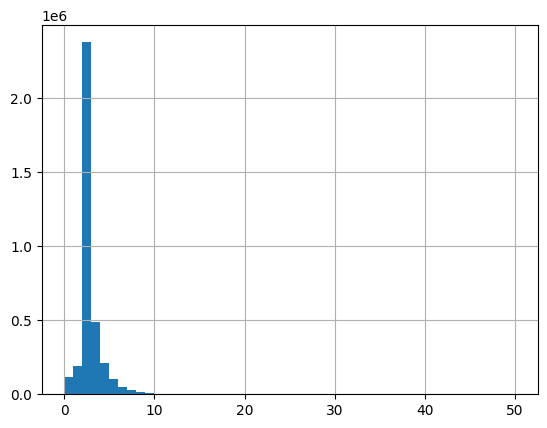

In [226]:
clean_and_processed_data['Score_Z_score_0_50'].hist(bins=50)

# Modelin'

In [180]:
X_train, X_test, y_train, y_test = train_test_split(clean_and_processed_data.drop('Score_Z_score_0_50',
                                                                                axis=1), clean_and_processed_data['Score_Z_score_0_50'], random_state=42)

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(processed_data.drop('Seg_3_OperatingCarrierIATA',
                                                                                axis=1), processed_data['Seg_3_OperatingCarrierIATA'], random_state=42)


In [181]:
X_test

,Stops,DurationMin,total_layover_time_ratio,OriginApt_0,OriginApt_1,OriginApt_2,OriginApt_3,OriginApt_4,OriginApt_5,OriginApt_6,...,DestinationApt_10,DestinationApt_11,total_distance_traveled,extra_travel_distance_ratio,TravelHorizonDays,TravelDistanceKm,PricePerPax,SelfTransfer,sin_day,cos_day
344754,0.0,2.742282,0.0,0,0,0,0,0,1,1,...,0,1,6.174230,0.0,0.300000,6.302774,4.405216,1,7.818315e-01,0.623490
439405,0.0,2.784620,0.0,0,0,1,0,0,0,0,...,0,0,6.272209,0.0,0.466667,6.405260,4.212942,1,-4.338837e-01,-0.900969
3580513,0.0,2.752861,0.0,0,0,0,1,1,1,0,...,1,1,6.183994,0.0,0.900000,6.312984,4.160758,1,4.338837e-01,-0.900969
1021303,0.0,2.592456,0.0,0,0,1,0,0,1,0,...,1,0,5.553989,0.0,0.033333,5.655715,4.179231,1,-4.338837e-01,-0.900969
1855034,0.0,2.624260,0.0,0,0,0,0,0,1,1,...,1,0,5.762006,0.0,0.500000,5.872415,4.145012,1,9.749279e-01,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039027,0.0,2.892432,0.0,0,0,1,0,0,0,1,...,0,0,6.828026,0.0,0.500000,6.988199,5.238905,1,4.338837e-01,-0.900969
2311511,0.0,2.831564,0.0,0,0,0,1,1,1,0,...,1,1,6.477683,0.0,0.700000,6.620447,4.298078,1,-2.449294e-16,1.000000
3074306,0.0,2.816104,0.0,0,0,0,0,0,1,0,...,0,0,6.450510,0.0,0.166667,6.591968,4.668473,1,9.749279e-01,-0.222521
2713440,0.0,2.735351,0.0,0,0,0,1,1,0,1,...,0,0,6.137987,0.0,0.166667,6.264885,5.332234,1,9.749279e-01,-0.222521


In [182]:
X_train.shape


(2698311, 35)

In [217]:
model = Sequential()
model.add(layers.Dense(64, input_dim=35, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='linear'))


In [218]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=1, mode='min', restore_best_weights=True)


In [219]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])


In [220]:
model.fit(X_train, y_train, epochs=10, batch_size=256, verbose=1, callbacks=[early_stopping], validation_split=0.2)


Epoch 1/10
8433/8433 [==============================] - 9s 993us/step - loss: 1.7449 - mae: 0.8554 - val_loss: 1.7271 - val_mae: 0.8201
Epoch 2/10
8433/8433 [==============================] - 8s 892us/step - loss: 1.7269 - mae: 0.8527 - val_loss: 1.7207 - val_mae: 0.8759
Epoch 3/10
8433/8433 [==============================] - 7s 885us/step - loss: 1.7241 - mae: 0.8524 - val_loss: 1.7144 - val_mae: 0.8496
Epoch 4/10
8433/8433 [==============================] - 7s 889us/step - loss: 1.7215 - mae: 0.8520 - val_loss: 1.7113 - val_mae: 0.8504
Epoch 5/10
8433/8433 [==============================] - 7s 882us/step - loss: 1.7200 - mae: 0.8518 - val_loss: 1.7107 - val_mae: 0.8481
Epoch 6/10
8433/8433 [==============================] - 7s 886us/step - loss: 1.7187 - mae: 0.8515 - val_loss: 1.7107 - val_mae: 0.8519
Epoch 7/10
8433/8433 [==============================] - 7s 885us/step - loss: 1.7174 - mae: 0.8512 - val_loss: 1.7106 - val_mae: 0.8575
Epoch 7: early stopping


In [187]:
# model = load_model('../models/ant_model_021223.h5')
model.save('../models/ant_model_131223_v2.h5')


/Users/antonis/.pyenv/versions/3.11.2/envs/OptiEnv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [221]:
test_loss, test_error = model.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"Test Loss (MSE): {test_loss}")
print(f"Test Error (MAE): {test_error}")


28108/28108 [==============================] - 10s 342us/step - loss: 1.7066 - mae: 0.8508
Test Loss (MSE): 1.7065811157226562
Test Error (MAE): 0.8507538437843323


In [222]:
y_pred = model.predict(X_test)


28108/28108 [==============================] - 8s 300us/step


In [223]:
y_pred.reshape(-1)


array([2.861264 , 2.8023224, 2.7267952, ..., 3.0043747, 2.9393096,
       2.8857841], dtype=float32)

array([[<Axes: title={'center': '0'}>]], dtype=object)

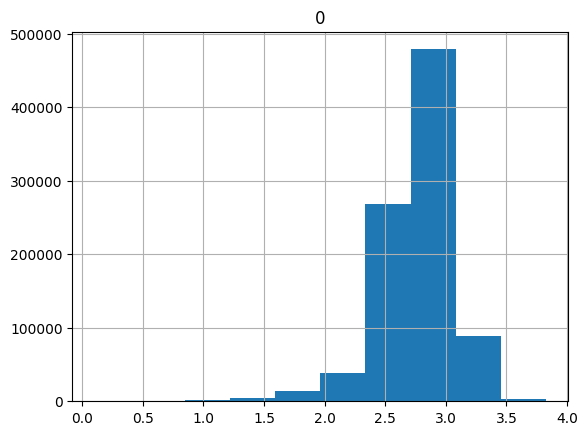

In [224]:
pd.DataFrame(y_pred).hist()

In [192]:
knn_50_performance_df = pd.DataFrame({'true_value':y_test, 'pred_value':y_pred.reshape(-1), 'DurationMin':X_test['DurationMin'],
                                  "ODRedirects":X_test_all['ODRedirects'], "ItineraryRedirects":X_test_all['ItineraryRedirects'],
                                  'Stops':X_test_all['Stops'], 'redirect_ratio':X_test_all['redirect_ratio']})

knn_50_performance_df['difference'] = knn_50_performance_df['pred_value'] - knn_50_performance_df['true_value']


<Axes: xlabel='ODRedirects', ylabel='difference'>

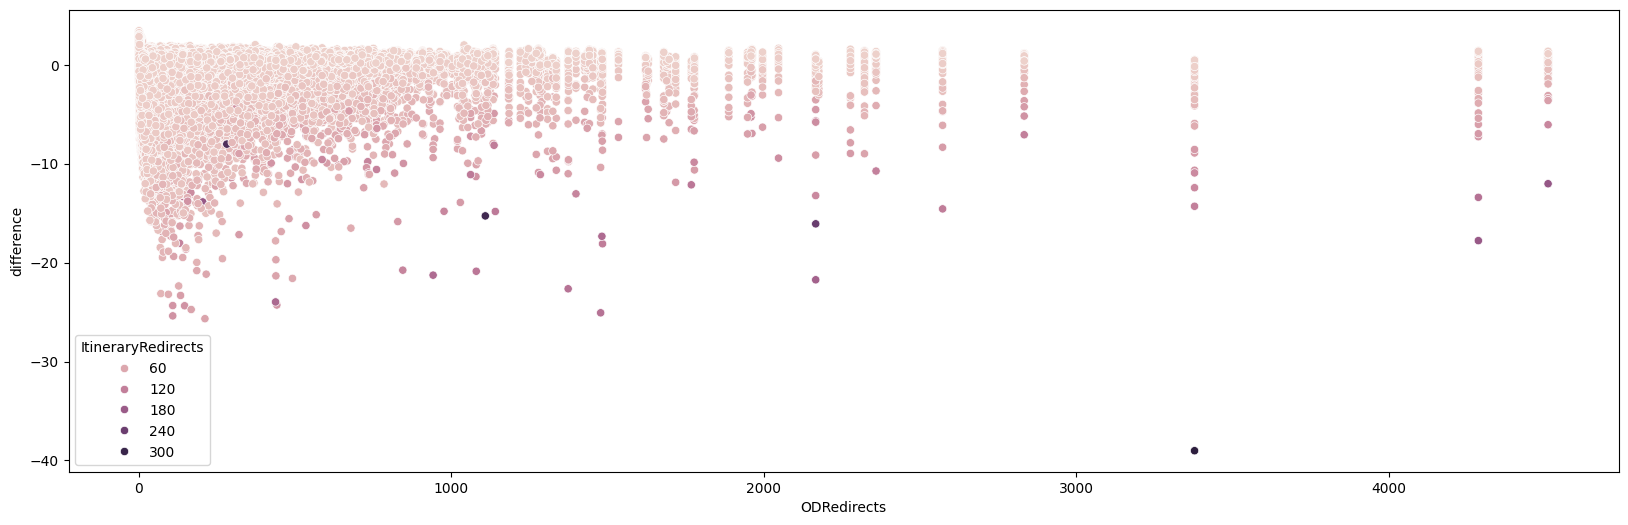

In [193]:
plt.figure(figsize=(20, 6))
sns.scatterplot(knn_50_performance_df, x='ODRedirects', y='difference', alpha=1, hue='ItineraryRedirects')


# Random Forrest model

In [150]:
# rf_regressor = RandomForestRegressor(n_estimators=10, n_jobs=-1, max_depth=20, )

# rf_regressor.fit(X_train, y_train)


In [151]:
# rf_y_pred = rf_regressor.predict(X_test)

# rf_y_pred.reshape(-1)

# rf_performance_df = pd.DataFrame({'true_value':y_test, 'pred_value':rf_y_pred.reshape(-1), 'DurationMin':X_test['DurationMin'],
#                                   "ODRedirects":X_test_all['ODRedirects'], "ItineraryRedirects":X_test_all['ItineraryRedirects'],
#                                   'Stops':X_test_all['Stops'], 'redirect_ratio':X_test_all['redirect_ratio']})

# rf_performance_df['difference'] = rf_performance_df['pred_value'] - rf_performance_df['true_value']


In [152]:
# plt.figure(figsize=(20, 6))
# sns.scatterplot(rf_performance_df, x='ODRedirects', y='difference', alpha=1, hue='ItineraryRedirects')


# Dohop test dataset

In [194]:
raw_dohop_data = pd.read_csv('../raw_data/bq-results-20231211-194938-1702324257187.csv')

copy_data = raw_dohop_data.copy()

dohop_data = copy_data[~copy_data['itinerary_fare'].isna()]


In [195]:
dohop_data.reset_index(drop=True, inplace=True)


In [196]:
# dohop_data['seg_0'] = 0
# dohop_data['seg_1'] = 0

# for i in range(len(dohop_data)):
#     listtt = dohop_data['flights'][i].split(',')
#     dohop_data['seg_0'][i] = listtt[0][:2]
#     dohop_data['seg_1'][i] = listtt[1].strip()[:2]


/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_29396/3831053749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dohop_data['seg_0'] = 0
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_29396/3831053749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dohop_data['seg_1'] = 0
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_29396/3831053749.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

In [197]:
dohop_data['DurationMin'] = dohop_data['total_flight_time'] + dohop_data['connection_time']
dohop_data['total_layover_time_ratio'] = dohop_data['connection_time'] / dohop_data['DurationMin']


/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_29396/1285210725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dohop_data['DurationMin'] = dohop_data['total_flight_time'] + dohop_data['connection_time']
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_29396/1285210725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dohop_data['total_layover_time_ratio'] = dohop_data['connection_time'] / dohop_data['DurationMin']


In [198]:
# This was for an old dataset

# col_rename_dict = {'origin': 'OriginApt', 'destination':'DestinationApt', 'days_to_travel':'TravelHorizonDays', 'total_distance':'total_distance_traveled',
#                    'direct_distance':'TravelDistanceKm', 'total_minutes':'DurationMin', 'connection_time':'total_layover_time',
#                    'seg_0':'Seg_0_OperatingCarrierIATAa', 'seg_1':'Seg_1_OperatingCarrierIATA', 'seg_2':'Seg_2_OperatingCarrierIATA', 'seg_3':'Seg_3_OperatingCarrierIATA'}


col_rename_dict = {'origin_iata': 'OriginApt', 'destination_iata':'DestinationApt', 'days_to_travel':'TravelHorizonDays', 'total_distance':'total_distance_traveled',
                   'direct_distance':'TravelDistanceKm', 'connection_time':'total_layover_time', 'itinerary_fare':'PricePerPax',
                   'seg_0':'Seg_0_OperatingCarrierIATA', 'seg_1':'Seg_1_OperatingCarrierIATA', 'seg_2':'Seg_2_OperatingCarrierIATA', 'seg_3':'Seg_3_OperatingCarrierIATA'}


In [199]:
dohop_data.drop(columns=['flights', 'connection_airport', 'pax',
                         'bookings', 'booked_fare', 'total_flight_time'], inplace=True)


/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_29396/2724626855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dohop_data.drop(columns=['flights', 'connection_airport', 'pax',


In [200]:
update_col_names = dohop_data.rename(columns=col_rename_dict)


In [201]:
update_col_names["Seg_2_OperatingCarrierIATA"] = np.nan
update_col_names["Seg_3_OperatingCarrierIATA"] = np.nan
update_col_names["Stops"] = 1
update_col_names["SelfTransfer"] = 1


In [202]:
update_col_names['extra_travel_distance_ratio'] = update_col_names['total_distance_traveled'] / update_col_names['TravelDistanceKm']


In [203]:
update_col_names.columns


Index(['OriginApt', 'DestinationApt', 'total_layover_time',
       'TravelHorizonDays', 'dayofweek', 'total_distance_traveled',
       'TravelDistanceKm', 'PricePerPax', 'Seg_0_OperatingCarrierIATA',
       'Seg_1_OperatingCarrierIATA', 'DurationMin', 'total_layover_time_ratio',
       'Seg_2_OperatingCarrierIATA', 'Seg_3_OperatingCarrierIATA', 'Stops',
       'SelfTransfer', 'extra_travel_distance_ratio'],
      dtype='object')

In [204]:
columns_v2 = ['Stops','DurationMin', 'total_layover_time_ratio', 'OriginApt', 'DestinationApt',
            'total_distance_traveled','extra_travel_distance_ratio', 'TravelHorizonDays', 'dayofweek',
            'TravelDistanceKm', 'PricePerPax', 'SelfTransfer']

box_cox_columns = ['DurationMin', 'TravelDistanceKm','extra_travel_distance_ratio', 'PricePerPax']

yeo_johnson_columns = ['total_layover_time_ratio', 'total_distance_traveled']

min_max_scaling = ['TravelHorizonDays','Stops']


In [205]:
update_col_names[columns_v2]


,Stops,DurationMin,total_layover_time_ratio,OriginApt,DestinationApt,total_distance_traveled,extra_travel_distance_ratio,TravelHorizonDays,dayofweek,TravelDistanceKm,PricePerPax,SelfTransfer
0,1,410,0.512195,TLS,FCO,1714.360,1.854818,3,2,924.274,104.667500,1
1,1,425,0.247059,AGP,ARN,3015.741,1.016140,12,4,2967.841,173.426667,1
2,1,390,0.589744,FCO,TLS,1107.049,1.197750,3,2,924.274,112.763333,1
3,1,425,0.352941,LIS,BER,2549.215,1.106451,7,6,2303.957,159.526806,1
4,1,505,0.346535,PRG,KEF,2906.959,1.101503,15,7,2639.083,139.332500,1
...,...,...,...,...,...,...,...,...,...,...,...,...
867293,1,1530,0.372549,TFS,LAX,11727.578,1.263142,29,7,9284.452,524.023104,1
867294,1,690,0.688406,ABZ,NCE,1672.391,1.018478,2,1,1642.049,186.831250,1
867295,1,690,0.688406,ABZ,NCE,1672.391,1.018478,9,1,1642.049,171.790937,1
867296,1,450,0.522222,MRS,ZRH,1752.698,3.389974,17,2,517.024,154.540375,1


In [207]:
scaled_dohop_data = process_new_data(df_with_target, update_col_names[columns_v2], PreprocessScalers,
                                     box_cox_columns, yeo_johnson_columns)


(867298, 23)
(867298, 34)
(867298, 34)
(867298, 34)
(867298, 34)
(867298, 35)


In [208]:
model = load_model('../models/ant_model_131223.h5')


In [209]:
dohop_pred = model.predict(scaled_dohop_data)


27104/27104 [==============================] - 9s 347us/step


array([[<Axes: title={'center': '0'}>]], dtype=object)

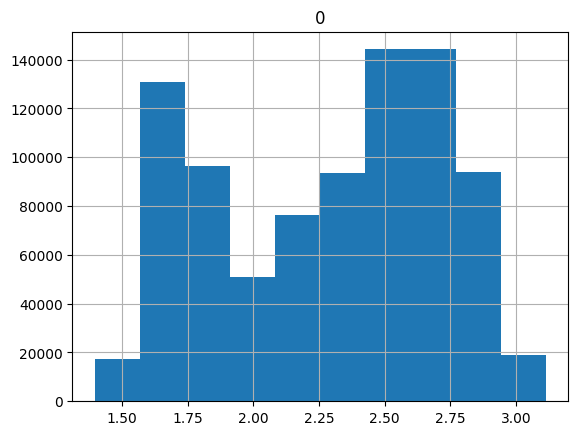

In [210]:
pd.DataFrame(dohop_pred).hist()

In [211]:
raw_dohop_data['bookings'] = raw_dohop_data['bookings'].fillna(0)


In [212]:
clean_raw_dohop_data = raw_dohop_data.dropna(subset='itinerary_fare')


In [213]:
clean_raw_dohop_data['y_pred'] = dohop_pred


/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_29396/735542922.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_raw_dohop_data['y_pred'] = dohop_pred


In [214]:
clean_raw_dohop_data


,flights,origin_iata,destination_iata,connection_airport,total_flight_time,connection_time,days_to_travel,dayofweek,pax,bookings,booked_fare,total_distance,direct_distance,itinerary_fare,y_pred
0,"U24706, U24743",TLS,FCO,NTE,200,210,3,2,11.0,7.0,147.763456,1714.360,924.274,104.667500,2.111990
1,"U21388, U21595",AGP,ARN,GVA,320,105,12,4,5.0,4.0,168.904838,3015.741,2967.841,173.426667,2.860464
2,"U24412, U24325",FCO,TLS,LYS,160,230,3,2,7.0,4.0,233.022479,1107.049,924.274,112.763333,2.525755
3,"U27617, U25146",LIS,BER,NCE,275,150,7,6,4.0,4.0,146.028624,2549.215,2303.957,159.526806,2.844875
4,"U28782, U28845",PRG,KEF,LGW,330,175,15,7,3.0,3.0,177.352702,2906.959,2639.083,139.332500,2.806916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019368,"U28054, Z0711",TFS,LAX,LGW,960,570,29,7,NaN,0.0,NaN,11727.578,9284.452,524.023104,2.431132
2019369,"U2856, U28419",ABZ,NCE,LGW,215,475,2,1,NaN,0.0,NaN,1672.391,1642.049,186.831250,2.686637
2019370,"U2856, U28419",ABZ,NCE,LGW,215,475,9,1,NaN,0.0,NaN,1672.391,1642.049,171.790937,2.539777
2019374,"U28440, U28473",MRS,ZRH,LGW,215,235,17,2,NaN,0.0,NaN,1752.698,517.024,154.540375,1.647056


<Axes: xlabel='bookings', ylabel='y_pred'>

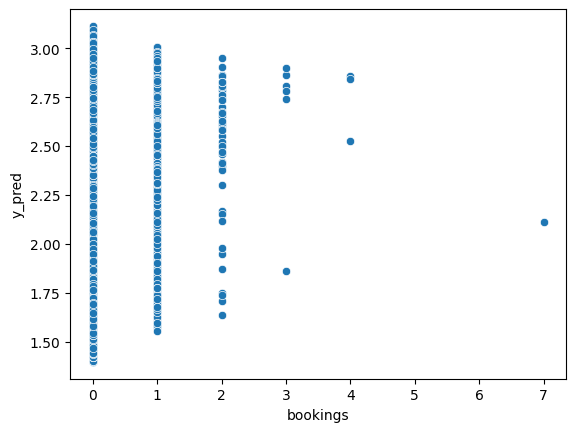

In [216]:
sns.scatterplot(data=clean_raw_dohop_data, x='bookings', y='y_pred')
